In [1]:
#  Import libraries
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load Preprocessed Data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test_X_train_encoded_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test_X_test_encoded_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test_y_train.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test_y_test.csv").squeeze()


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Check input shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (182690, 11)
y_train shape: (182690,)


In [6]:
# Get number of features and classes
num_features = X_train.shape[1]
num_classes = len(set(y_train))  # Should be 3 for your data

# Build baseline MLP
model = keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,755 (42.01 KB)

 Trainable params: 10,371 (40.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

def glu(x, units):
    """Gated Linear Unit activation."""
    linear = layers.Dense(units)(x)
    gate = layers.Dense(units, activation='sigmoid')(x)
    return layers.Multiply()([linear, gate])

def feature_transformer(x, units):
    """A basic feature transformer block."""
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = glu(x, units)
    return x

def attentive_transformer(x, prior_scales, units):
    """Attentive transformer block for feature selection."""
    mask_logits = layers.Dense(units)(x)
    mask = layers.Activation('softmax')(mask_logits)  # Use sparsemax for true TabNet if you implement it!
    mask = layers.Multiply()([mask, prior_scales])
    return mask

def tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=3):
    prior = layers.Lambda(lambda x: K.ones_like(x))(inputs)  # Start with "all features allowed"
    masked_features = inputs
    step_outputs = []

    for step in range(num_steps):
        # Feature transformer
        x = feature_transformer(masked_features, feature_dim)
        # Attentive transformer to produce feature mask
        mask = attentive_transformer(x, prior, inputs.shape[-1])
        # Update masked features
        masked_features = layers.Multiply()([inputs, mask])
        # Decision output for this step
        out = layers.Dense(feature_dim, activation='relu')(masked_features)
        step_outputs.append(out)
        # Update prior (discourage re-selection)
        prior = layers.Multiply()([prior, layers.Lambda(lambda x: 1. - x)(mask)])

    # Aggregate outputs (TabNet does a weighted sum)
    final_out = layers.Add()(step_outputs)
    final_out = layers.Dense(output_dim, activation='softmax')(final_out)
    return final_out




In [8]:
# --- Main Model ---
num_features = X_train.shape[1]
num_classes = len(set(y_train))

inputs = Input(shape=(num_features,))
outputs = tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=num_classes)

tabnet_model = Model(inputs=inputs, outputs=outputs)
tabnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
tabnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        768 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 11)        │        715 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 11)        │          0 │ dense_6[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 11)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 11)        │          0 │ activation[0][0], │
│ (Multiply)          │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 11)        │          0 │ input_layer_1[0]… │
│ (Multiply)          │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        768 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64)        │          0 │ dense_9[0][0],    │
│ (Multiply)          │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 11)        │        715 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 11)        │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 11)        │          0 │ dense_11[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 11)        │          0 │ lambda[0][0],     │
│ (Multiply)          │                   │            │ lambda_1[0][0]  

 Total params: 32,676 (127.64 KB)

 Trainable params: 32,292 (126.14 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
history = tabnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,    # Adjust as needed
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6698 - loss: 0.7389 - val_accuracy: 0.7762 - val_loss: 0.5177
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7754 - loss: 0.5157 - val_accuracy: 0.7891 - val_loss: 0.4856
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7846 - loss: 0.4878 - val_accuracy: 0.7852 - val_loss: 0.4728
Epoch 4/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7883 - loss: 0.4714 - val_accuracy: 0.7965 - val_loss: 0.4522
Epoch 5/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7896 - loss: 0.4618 - val_accuracy: 0.7984 - val_loss: 0.4440
Epoch 6/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7928 - loss: 0.4528 - val_accuracy: 0.8006 - val_loss: 0.4375
Epoch 7/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7938 - loss: 0.4473 - val_accuracy: 0.7984 - val_loss: 0.4340
Epoch 8/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7951 - loss: 0.4437 - val_accuracy: 

In [10]:
from sklearn.metrics import classification_report

y_pred = tabnet_model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     30732
           1       0.82      0.81      0.82     28383
           2       0.76      0.76      0.76     19181

    accuracy                           0.81     78296
   macro avg       0.80      0.80      0.80     78296
weighted avg       0.81      0.81      0.81     78296



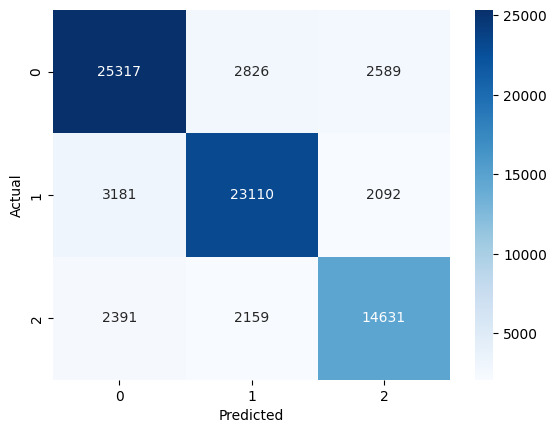

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━

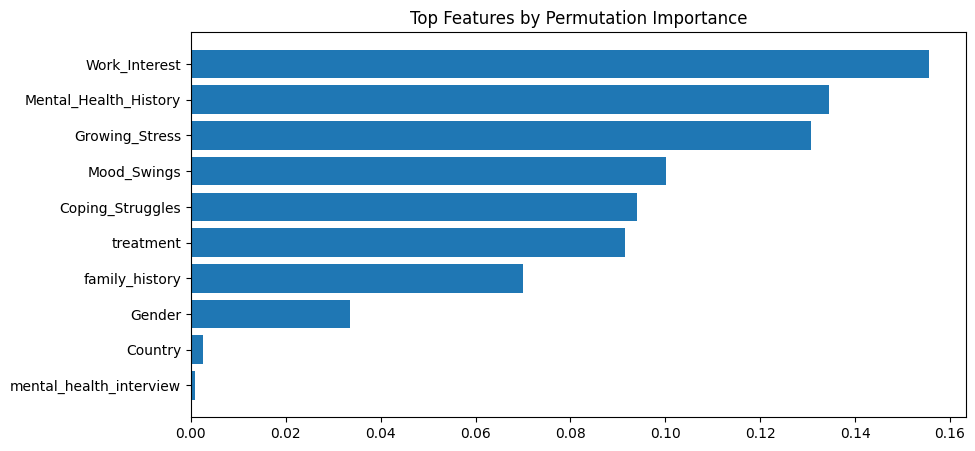

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score

def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=5):
    baseline = metric(y, model.predict(X).argmax(axis=1))
    importances = []
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(y, model.predict(X_permuted).argmax(axis=1))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

# Usage:
X_test_np = X_test.values if hasattr(X_test, "values") else X_test  # ensure it's a numpy array
importances = permutation_importance(tabnet_model, X_test_np, y_test)

# Plot top features
import matplotlib.pyplot as plt
feature_names = X_test.columns
top_idx = np.argsort(importances)[-10:]
plt.figure(figsize=(10,5))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.title("Top Features by Permutation Importance")
plt.show()


## Top Feature Interpretations – Global Model View

| **Feature**               | **Interpretation**                                                                                       |
|---------------------------|---------------------------------------------------------------------------------------------------------|
| **Work_Interest**         | The strongest predictor. Declining interest in work is a prominent indicator of mental health risk, likely reflecting disengagement, lack of motivation, or early symptoms of distress. |
| **Mental_Health_History** | A significant risk anchor. Past or current mental health issues remain highly predictive for ongoing risk, aligning with clinical expectations. |
| **Growing_Stress**        | Sustained or increasing stress levels are closely tied to elevated risk, highlighting the central role of stress in mental health outcomes. |
| **Mood_Swings**           | Mood instability is a key sign of mental health challenges and strongly influences risk classification. |
| **Coping_Struggles**      | Difficulty managing everyday stressors is predictive of higher risk, reflecting resilience and adaptive capacity. |
| **treatment**             | Individuals currently in or seeking treatment are at greater risk, as treatment-seeking often follows acute or ongoing problems. |
| **family_history**        | Family mental health history is a well-known risk factor, confirming its importance for risk stratification. |
| **Gender**                | While less influential than behavioral factors, gender differences may capture demographic risk patterns. |
| **Country**               | Minimal impact, suggesting risk patterns are relatively consistent across countries in this dataset. |
| **mental_health_interview** | Limited importance, indicating interview status is not a major driver of model predictions. |

---

### **Interpretation:**
The model’s predictions are most strongly driven by **work engagement, personal mental health history, and stress-related variables**. Mood-related symptoms and coping capacity add further predictive power, while demographic and geographic factors have a lesser influence. These results reflect established clinical insights: **dynamic behavioral and psychological factors are the most actionable signals for mental health risk**, whereas static factors like country and gender play a secondary role.

---

### **Summary:**
This analysis demonstrates that the model identifies risk primarily through patterns of work disengagement, prior mental health concerns, and stress or coping difficulties. Family history and treatment status provide context but are less decisive than real-time changes in behavior or wellbeing. These findings reinforce the value of monitoring workplace engagement, stress, and resilience for early risk detection and intervention.


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


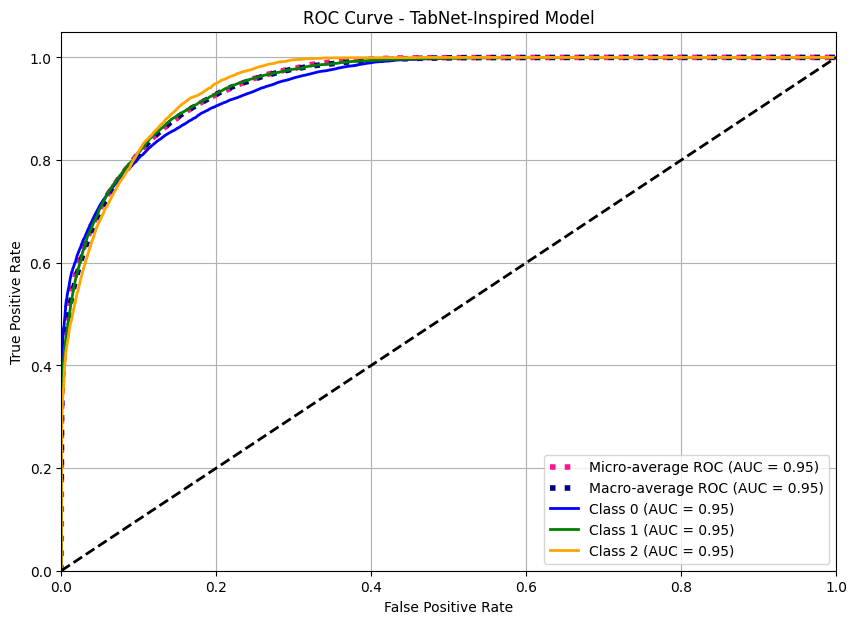

In [13]:
from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]


y_score = tabnet_model.predict(X_test)  # shape: (n_samples, n_classes)


from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

colors = ['blue', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - TabNet-Inspired Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()




## Model Evaluation Summary (TabNet-Inspired Model)

| **Metric**                   | **Value** | **Comment**                                                                 |
|------------------------------|-----------|------------------------------------------------------------------------------|
| **Accuracy**                 | 0.81      | Strong overall performance for a multiclass problem with moderate class overlap |
| **Precision (macro avg)**    | 0.80      | Good precision across all classes                                            |
| **Recall (macro avg)**       | 0.80      | Good sensitivity; captures most true positives                               |
| **F1-Score (macro avg)**     | 0.80      | Balanced precision and recall                                                |
| **Precision (weighted avg)** | 0.81      | Reflects class distribution and imbalance                                    |
| **Recall (weighted avg)**    | 0.81      | Robust even with uneven class sizes                                          |
| **F1-Score (weighted avg)**  | 0.81      | Reliable model performance                                                   |
| **ROC AUC (micro-average)**  | 0.95      | High overall capability to distinguish between classes                       |
| **ROC AUC (macro-average)**  | 0.95      | Excellent average separability across classes                                |
| **Class 0 AUC**              | 0.95      | Excellent discrimination for Class 0                                         |
| **Class 1 AUC**              | 0.95      | Excellent discrimination for Class 1                                         |
| **Class 2 AUC**              | 0.95      | Excellent discrimination for Class 2                                         |
| **Confusion Matrix**         | Most values along diagonal, but increased off-diagonal counts vs. baseline | Moderate misclassification, especially between classes 1 and 2 |
| **Feature Importance**       | Work_Interest, Mental_Health_History, Growing_Stress, Mood_Swings, Coping_Struggles | Model relies most on behavioral, stress, and mental health history features |

---

**Interpretation:**  
The TabNet-inspired model achieved an accuracy of 0.81 and macro-averaged precision, recall, and F1-scores of 0.80, indicating balanced and reliable performance across all risk groups. ROC AUC values of 0.95 for each class and for macro/micro averages demonstrate the model’s strong capability to distinguish between risk categories, even in the absence of the most cluster-defining features. The confusion matrix shows most predictions are correct, with moderate overlap between neighboring risk groups. Feature importance analysis reveals the model primarily leverages work engagement, mental health history, and stress-related behavioral factors for risk prediction.

---
